# Rolling Window to select Ribs

In [18]:
# Cell 1: imports
import pandas as pd
import numpy as np
from scipy.ndimage import grey_opening
from scipy.signal  import find_peaks
import matplotlib.pyplot as plt


In [8]:
# Cell 2: prompt for inputs
input_xlsx   = input("Path to input Excel sheet with QGIS profile data: ").strip()
phys_window  = float(input("Baseline window length (same units as distance, Asmara uses 7): ").strip())
height_thr   = float(input("Min rib height above baseline (m) Asmara uses 0.2").strip())
output_xlsx  = input("Path for output Excel e.g. DrumlinNumber-RibNumber_IDs.xlsx: ").strip()


Path to input Excel sheet with QGIS profile data:  C:\Users\aalehrma\Documents\HARD_DRIVE_COPY\Dotson\Ribs\profiles\Drumlin1 rib profiles\1-47_profile.xlsx
Baseline window length (same units as distance, Asmara uses 7):  7
Min rib height above baseline (m) Asmara uses 0.2 0.2
Path for output Excel e.g. DrumlinNumber-RibNumber_IDs.xlsx:  C:\Users\aalehrma\Desktop\1-47_IDs.xlsx


In [10]:
# Cell 3: read sheets & init
sheets        = pd.read_excel(input_xlsx, sheet_name=None)
out_profiles  = {}
rib_summary   = []

In [12]:
# Cell 4: detrend + detect ribs
for name, df in sheets.items():
    if not {'distance','z'}.issubset(df.columns): 
        print(f"Skipping '{name}': missing cols"); continue

    d = df['distance']; spacing = d.diff().median()
    win_pts = int(phys_window/spacing) // 2 * 2 + 1
    
    z        = df['z'].values
    baseline = grey_opening(z, size=win_pts)
    zdt      = z - baseline

    peaks, _ = find_peaks(zdt, height=height_thr)
    df['baseline']    = baseline
    df['z_detrended'] = zdt
    df['is_rib']      = False
    df.loc[peaks, 'is_rib'] = True

    rib_summary += [
        {'profile': name,
         'distance': d.iat[i],
         'rib_height': zdt[i]}
        for i in peaks
    ]
    out_profiles[name] = df


❌ Skipping Sheet1: missing expected columns – "['rib_height'] not in index"
✔ Done – updated Excel with rib details


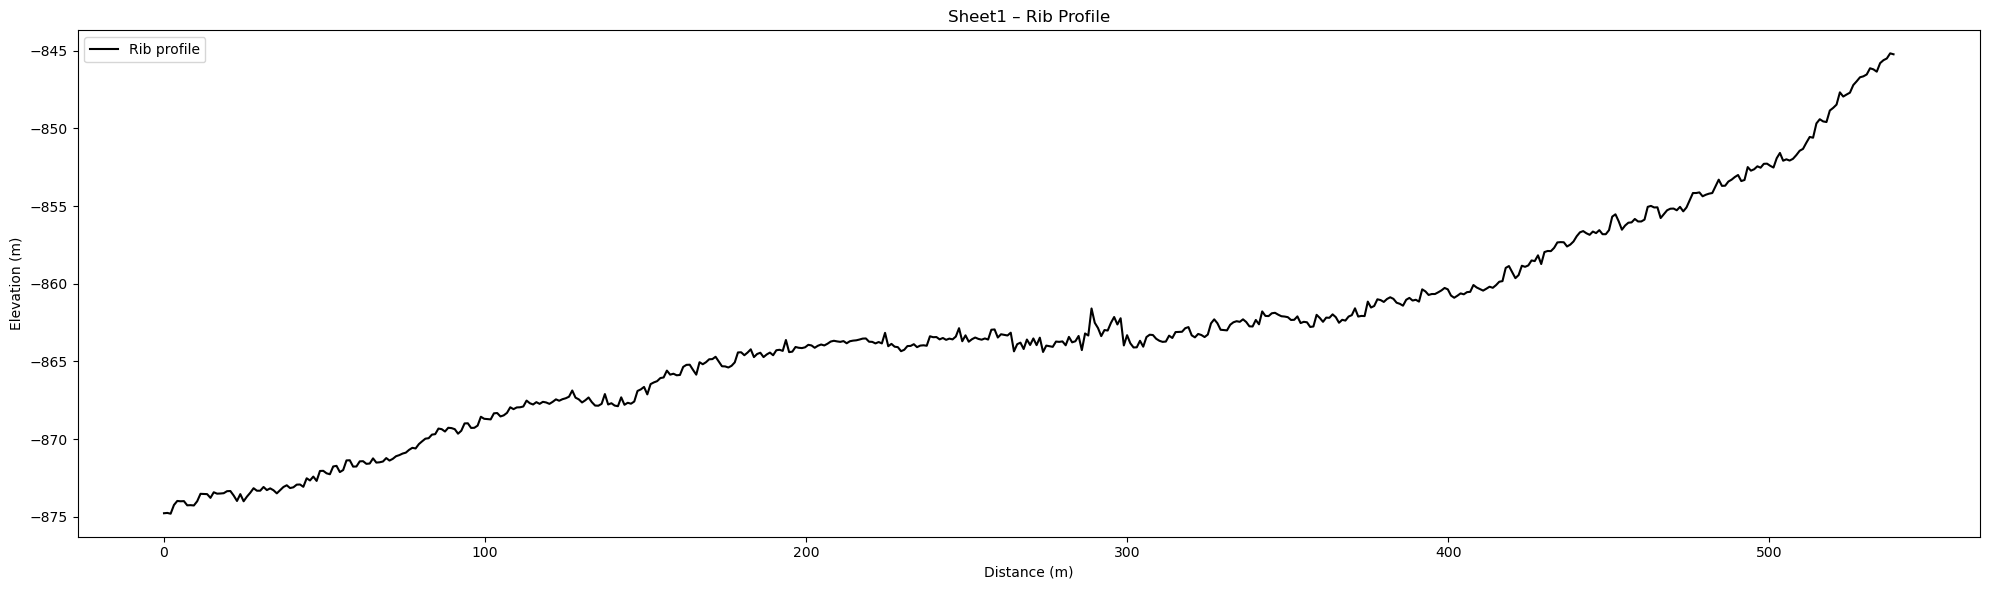

In [122]:
# Plot 1: Rib profile only
for name, df in out_profiles.items():
    s = df['distance'].values
    z = df['z'].values

    plt.figure(figsize=(20, 6))
    plt.plot(s, z, label='Rib profile', color='black')
    plt.title(f'{name} – Rib Profile')
    plt.xlabel('Distance (m)')
    plt.ylabel('Elevation (m)')
    plt.legend()
    plt.tight_layout()# Cell 7: write updated rib details per profile
with pd.ExcelWriter(output_xlsx, engine='openpyxl') as w:
    any_written = False

    for name, df in out_profiles.items():
        rib_df = df.loc[df['is_rib']].copy()

        if len(rib_df) == 0:
            print(f"⚠ Skipping {name} – no ribs detected")
            continue

        rib_df['rib_number'] = np.arange(1, len(rib_df) + 1)
        rib_df['spacing'] = rib_df['distance'].diff()

        # Use 'rib_height' directly if it already exists
        if 'rib_height' not in rib_df.columns and 'height' in rib_df.columns:
            rib_df = rib_df.rename(columns={'height': 'rib_height'})

        try:
            rib_output = rib_df[['rib_number', 'distance', 'rib_height', 'spacing']]
            rib_output.to_excel(w, sheet_name=f"{name} Details", index=False)
            any_written = True
        except KeyError as e:
            print(f"❌ Skipping {name}: missing expected columns – {e}")

    if 'rib_summary' in locals():
        pd.DataFrame(rib_summary).to_excel(w, sheet_name='rib_summary', index=False)
        any_written = True

    if not any_written:
        raise RuntimeError("No visible Excel sheets were written — check input data")

print("✔ Done – updated Excel with rib details")
plt.tight_layout()
plt.savefig("rib_profile.png", dpi=300)
plt.show()

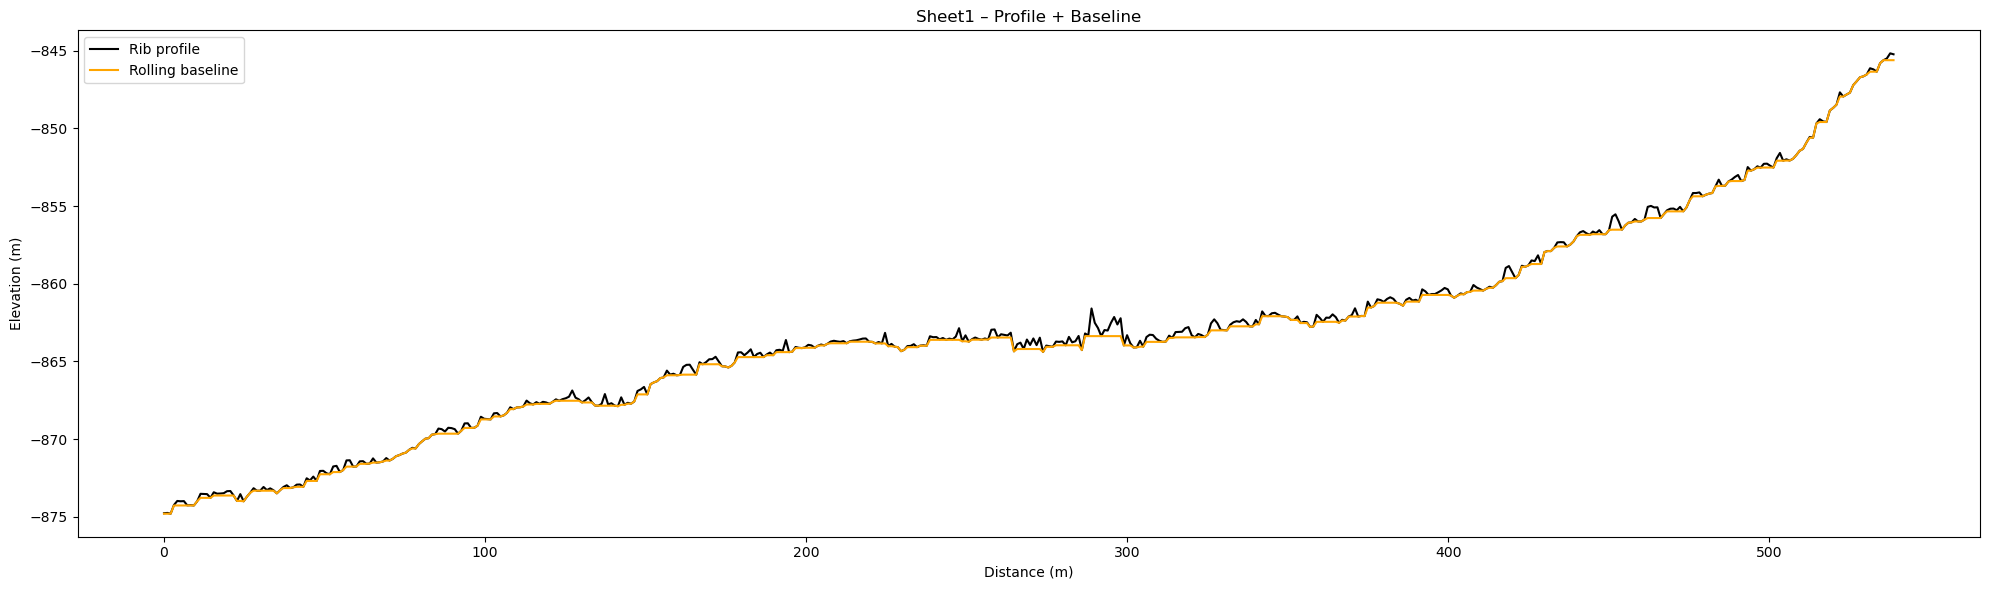

In [116]:
# Plot 2: Rib profile with rolling baseline
for name, df in out_profiles.items():
    s = df['distance'].values
    z = df['z'].values
    baseline = df['baseline'].values

    plt.figure(figsize=(20, 6))
    plt.plot(s, z, label='Rib profile', color='black')
    plt.plot(s, baseline, label='Rolling baseline', color='orange')
    plt.title(f'{name} – Profile + Baseline')
    plt.xlabel('Distance (m)')
    plt.ylabel('Elevation (m)')
    plt.legend()
    plt.tight_layout()
    plt.savefig("rib_profile_rollingwindow.png", dpi=300)
    plt.show()

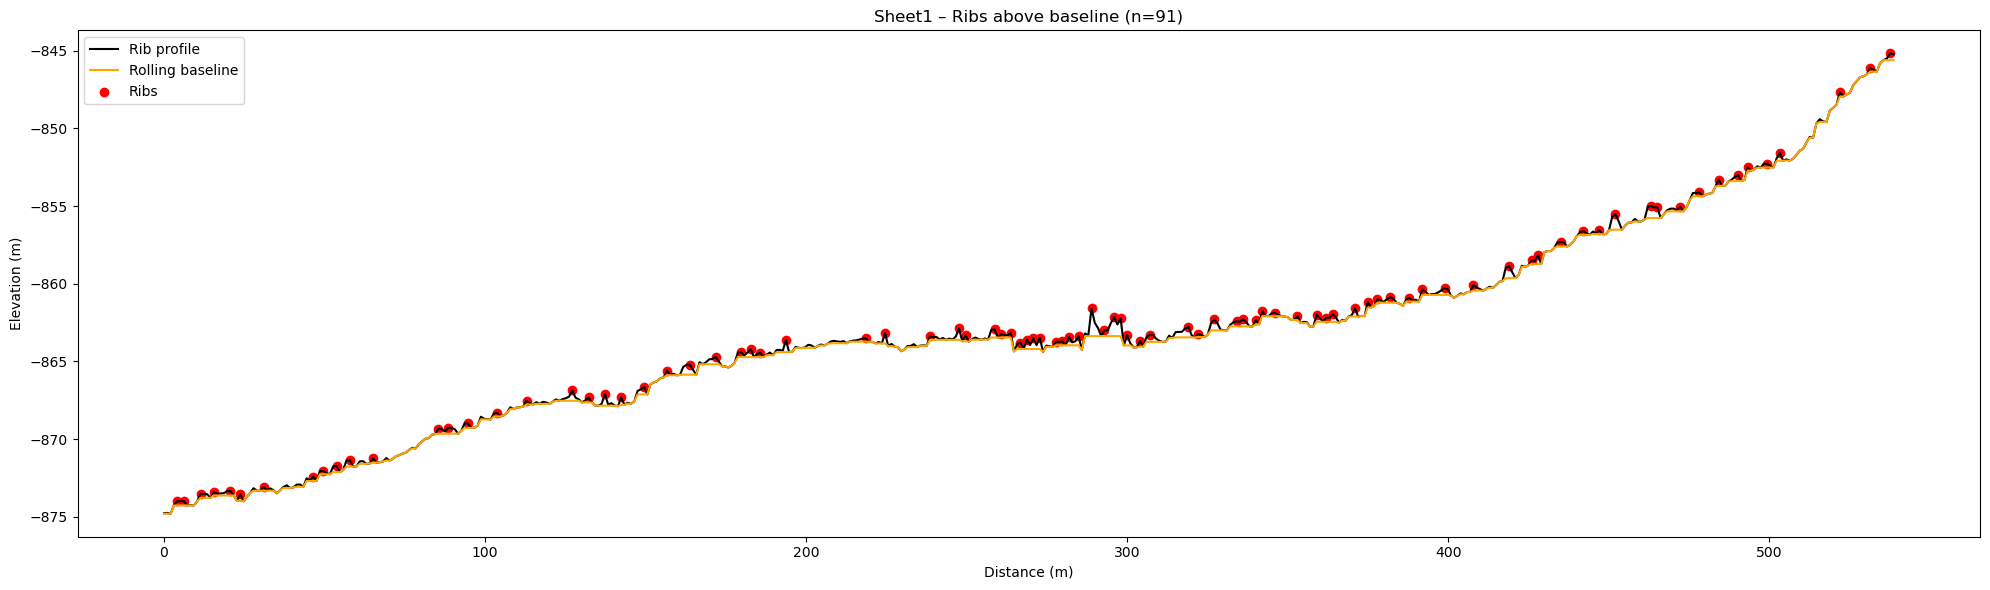

In [120]:
# Plot 3: Rib profile with rolling baseline and marked ribs
for name, df in out_profiles.items():
    s = df['distance'].values
    z = df['z'].values
    baseline = df['baseline'].values
    ribs = df.loc[df['is_rib'], 'distance'].values
    n_ribs = len(ribs)

    plt.figure(figsize=(20, 6))
    plt.plot(s, z, label='Rib profile', color='black')
    plt.plot(s, baseline, label='Rolling baseline', color='orange')
    plt.scatter(ribs, df.loc[df['is_rib'], 'z'].values, color='red', label='Ribs')
    plt.title(f'{name} – Ribs above baseline (n={n_ribs})')
    plt.xlabel('Distance (m)')
    plt.ylabel('Elevation (m)')
    plt.legend()
    plt.tight_layout()
    plt.savefig("rib_profile_ID.png", dpi=300)
    plt.show()

# Detrend

In [54]:
#Cell 1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import detrend, periodogram, find_peaks, windows


In [56]:
#Cell 2
details_path  = r"C:\Users\aalehrma\Documents\HARD_DRIVE_COPY\Dotson\Ribs\profiles\Drumlin1 rib profiles\1-47_rollingwindow7_ribID_details.xlsx"
sheet_name    = "Sheet1"
amp_col       = "height"
spacing_col   = "spacing"
sampling_interval = 1

details_df = pd.read_excel(details_path, sheet_name=sheet_name)


In [58]:
#Cell 2a
import numpy as np
from scipy.signal import detrend

# --- Height detrending ---
details_df['height_linreg'] = detrend(details_df['height'].values, type='linear')

details_df['height_smooth100'] = (
    details_df['height_linreg']
      .rolling(window=100, center=True, min_periods=1)
      .mean()

)
details_df['height_detrended_filtered'] = (
    details_df['height_linreg']
    - details_df['height_smooth100']
)

# --- Spacing detrending ---
spacing_raw = details_df['spacing'].values.astype(float)
valid_idx = np.isfinite(spacing_raw)

spacing_clean = spacing_raw[valid_idx]
spacing_linreg = detrend(spacing_clean, type='linear')

spacing_linreg_full = np.full_like(spacing_raw, np.nan)
spacing_linreg_full[valid_idx] = spacing_linreg
details_df['spacing_linreg'] = spacing_linreg_full

details_df['spacing_smooth100'] = (
    details_df['spacing_linreg']
      .rolling(window=100, center=True, min_periods=1)
      .mean()
)

details_df['spacing_detrended_filtered'] = (
    details_df['spacing_linreg']
    - details_df['spacing_smooth100']
)


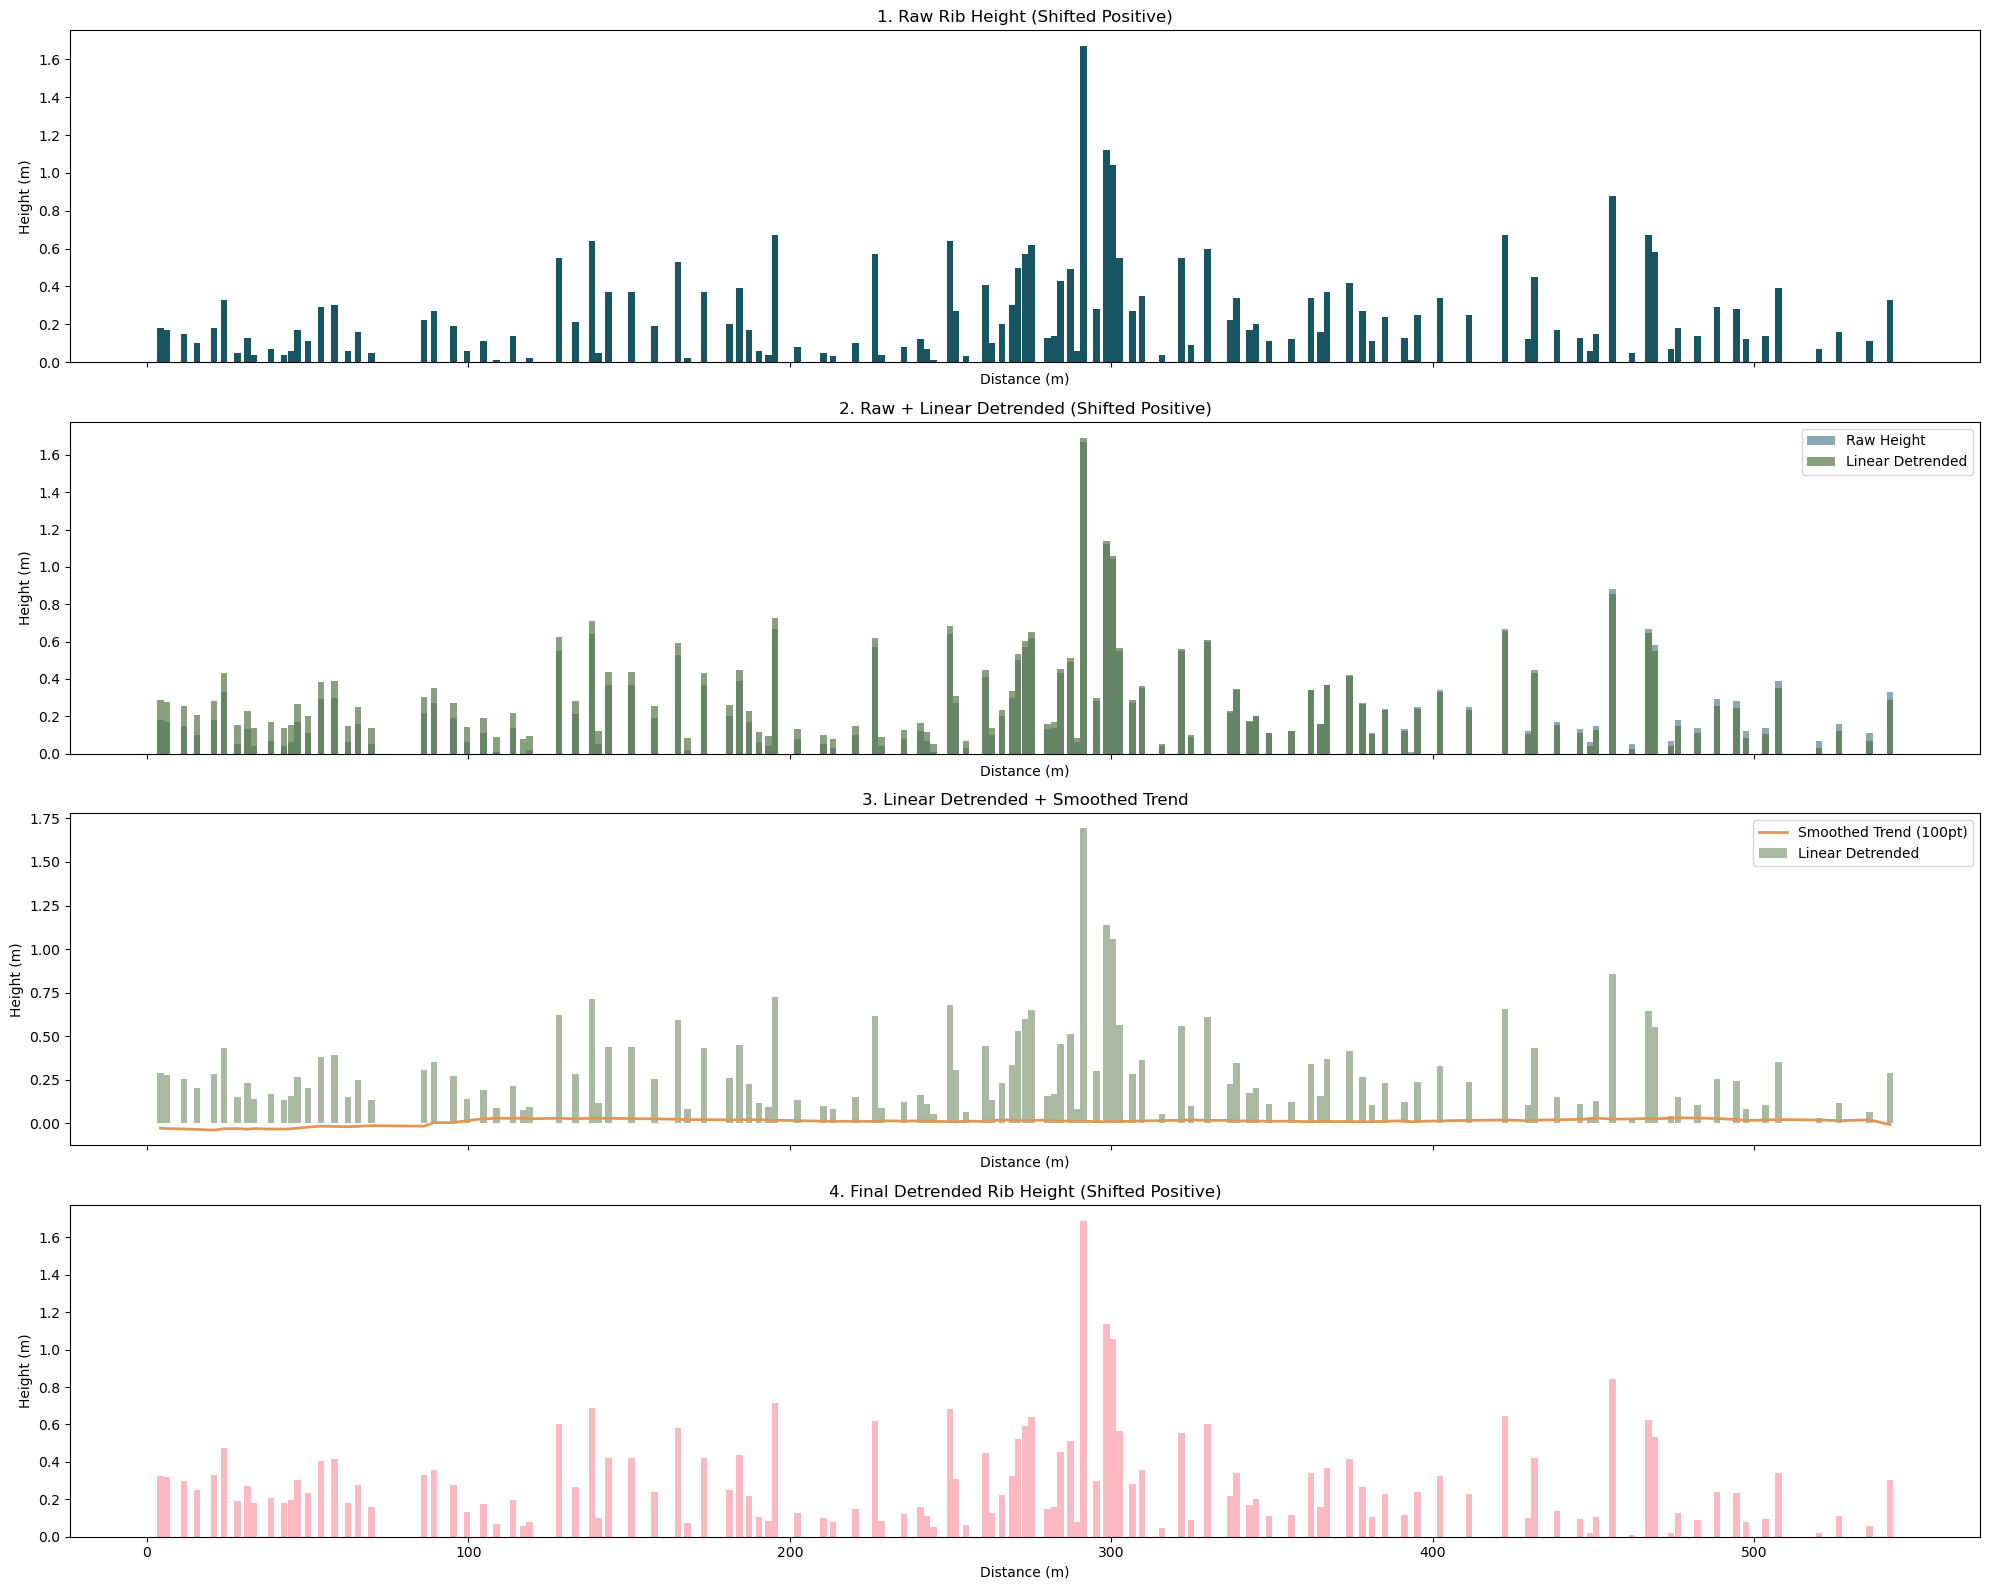

In [152]:
import matplotlib.pyplot as plt
from cmcrameri import cm

fig, axs = plt.subplots(4, 1, figsize=(20, 16), sharex=True)

# Choose consistent shades from batlow
c_raw     = cm.batlow(0.2)
c_lin     = cm.batlow(0.4)
c_smooth  = cm.batlow(0.7)
c_final   = cm.batlow(0.9)

# Shifted versions
height_raw_shifted     = details_df['height'] - details_df['height'].min()
height_linreg_shifted  = details_df['height_linreg'] - details_df['height_linreg'].min()
height_final_shifted   = details_df['height_detrended_filtered'] - details_df['height_detrended_filtered'].min()

# Plot 1: Raw
axs[0].bar(details_df['distance'], height_raw_shifted, width=2.0, color=c_raw)
axs[0].set_title("1. Raw Rib Height (Shifted Positive)")
axs[0].set_ylabel("Height (m)")
axs[0].set_xlabel("Distance (m)")

# Plot 2: Raw + Linear Detrended
axs[1].bar(details_df['distance'], height_raw_shifted, width=2.0, color=c_raw, label='Raw Height', alpha=0.5)
axs[1].bar(details_df['distance'], height_linreg_shifted, width=2.0, color=c_lin, label='Linear Detrended', alpha=0.7)
axs[1].set_title("2. Raw + Linear Detrended (Shifted Positive)")
axs[1].set_ylabel("Height (m)")
axs[1].set_xlabel("Distance (m)")
axs[1].legend()

# Plot 3: Linear Detrended + Smoothed Trend
axs[2].bar(details_df['distance'], height_linreg_shifted, width=2.0, color=c_lin, label='Linear Detrended', alpha=0.5)
axs[2].plot(details_df['distance'], details_df['height_smooth100'], color=c_smooth, label='Smoothed Trend (100pt)', linewidth=2)
axs[2].set_title("3. Linear Detrended + Smoothed Trend")
axs[2].set_ylabel("Height (m)")
axs[2].set_xlabel("Distance (m)")
axs[2].legend()

# Plot 4: Final Filtered Height (Shifted)
axs[3].bar(details_df['distance'], height_final_shifted, width=2.0, color=c_final)
axs[3].set_title("4. Final Detrended Rib Height (Shifted Positive)")
axs[3].set_ylabel("Height (m)")
axs[3].set_xlabel("Distance (m)")

plt.tight_layout()
plt.savefig("rib_profile_ID.png", dpi=300)
plt.show()


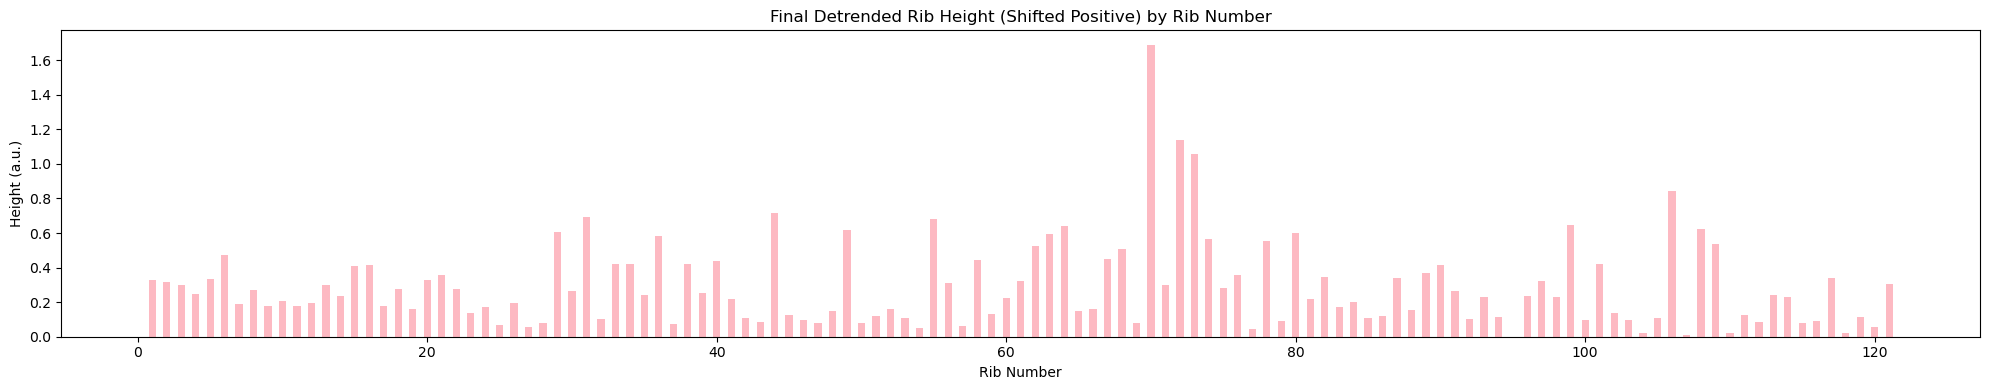

In [160]:
import matplotlib.pyplot as plt
from cmcrameri import cm

# Color from Batlow
c_final = cm.batlow(0.9)

# Rib numbers
rib_numbers = range(1, len(details_df) + 1)

# Shifted height (same as in original plot)
height_final_shifted = details_df['height_detrended_filtered'] - details_df['height_detrended_filtered'].min()

# Create the plot
plt.figure(figsize=(20, 4))
plt.bar(rib_numbers, height_final_shifted, width=0.5, color=c_final)
plt.title("Final Detrended Rib Height (Shifted Positive) by Rib Number")
plt.xlabel("Rib Number")
plt.ylabel("Height (a.u.)")
plt.tight_layout()
plt.show()


In [ ]:
# Plot 5B: Spacing detrending vs Distance
axs[1].plot(details_df['distance'], details_df['spacing'], label='Raw Spacing', color='black')
axs[1].plot(details_df['distance'], details_df['spacing_linreg'], label='Linear Detrended', color='blue')
axs[1].plot(details_df['distance'], details_df['spacing_smooth100'], label='Smoothed Trend (100pt)', color='orange')
axs[1].plot(details_df['distance'], details_df['spacing_detrended_filtered'], label='Final Detrended Spacing', color='green')
axs[1].set_ylabel("Spacing (m)")
axs[1].set_xlabel("Distance (m)")
axs[1].set_title("Spacing Detrending Steps")
axs[1].legend()

plt.tight_layout()
plt.show()


In [156]:
# Final export of properly detrended data (no slope correction)
output_df = pd.DataFrame({
    'rib_number': range(1, len(details_df) + 1),
    'detrended_height (au)': details_df['height_detrended_filtered'],
    'detrended spacing (au)': details_df['spacing_detrended_filtered']
})

rib_set_name = "1-47"
excel_path = f"{rib_set_name}_rib_detrended_summarycorrect.xlsx"
with pd.ExcelWriter(excel_path) as writer:
    output_df.to_excel(writer, sheet_name=f"{rib_set_name}", index=False)

print(f"Saved to {excel_path}")


Saved to 1-47_rib_detrended_summarycorrect.xlsx
